<a href="https://colab.research.google.com/github/climatechange-ai-tutorials/citylearn/blob/main/citylearn_ccai_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.9.13


The following Python packages are required (takes about 3 mins to run to completion in Colab):

In [24]:
%%capture

# the environment we will be working with and its dependencies
!pip install gymnasium
!pip install nrel-pysam
!pip install simplejson
# TODO: update to install stable version from PyPi
!pip install --no-deps CityLearn==2.2b0

# to generate static figures
!pip install matplotlib
!pip install seaborn

# provide standard RL algorithms
!pip install --no-deps stable-baselines3
# !pip install stable-baselines3


# results submission
!pip install requests
!pip install beautifulsoup4

# progress bar
!pip install tqdm

We can now import the relevant modules, classes and functions used in the tutorial:

In [62]:
# system operations
import inspect
import os
import uuid
import warnings

# date and time
import datetime

# type hinting
from typing import Any

# User interaction
from ipywidgets import Button, HTML
from ipywidgets import Text, HBox, VBox

# data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm import tqdm

# data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

import time
from tqdm import tqdm

# cityLearn
from citylearn.agents.base import (
    BaselineAgent,
    Agent as RandomAgent
)
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import (
    NormalizedObservationWrapper,
    StableBaselines3Wrapper,
    TabularQLearningWrapper,
    DiscreteActionWrapper
)

# RL algorithms
from stable_baselines3 import SAC, A2C, PPO, DDPG

Here we include some global settings we want applied for the remainder of the notebook:

In [26]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

# ignore deprecation warnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)

## Loading the Dataset

The dataset is included in the CityLearn package installation which we will now read into memory. To read the dataset, all we need is the name that references it:

In [27]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'

The dataset includes a schema, which is a `JSON` representation of the environment. This schema defines a `root_directory` key-value where all files that are relevant to this dataset are stored as well as the name of each file. We will use this root directory and filenames to read in and visualize the dataset files:

In [28]:
schema = DataSet.get_schema(DATASET_NAME)
root_directory = schema['root_directory']

### Preview a Building Data File
We can now preview the data files for one of the buildings in the `citylearn_challenge_2022_phase_all` dataset.

In [29]:
# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_2'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.188750,0.0,0.0,0.0,0.0
1,8,1,1,0,NaN,NaN,NaN,1.370667,0.0,0.0,0.0,0.0
2,8,2,1,0,NaN,NaN,NaN,1.101250,0.0,0.0,0.0,0.0
3,8,3,1,0,NaN,NaN,NaN,0.543217,0.0,0.0,0.0,0.0
4,8,4,1,0,NaN,NaN,NaN,0.542833,0.0,0.0,0.0,0.0


In [30]:
def select_simulation_period(
    dataset_name: str, count: int, seed: int,
    simulation_periods_to_exclude: list[tuple[int, int]] = None
) -> tuple[int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.
    simulation_periods_to_exclude: list[tuple[int, int]]
        List of simulation periods to exclude from selection pool.

    Returns
    -------
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps
    schema = DataSet.get_schema(dataset_name)
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # exclude period if needed
    if simulation_periods_to_exclude is not None:
        simulation_start_time_step_list_to_exclude = \
            [s for s, e in simulation_periods_to_exclude]
        simulation_start_time_step_list = np.setdiff1d(
            simulation_start_time_step_list,
            simulation_start_time_step_list_to_exclude
        )

    else:
        pass

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    return simulation_start_time_step, simulation_end_time_step




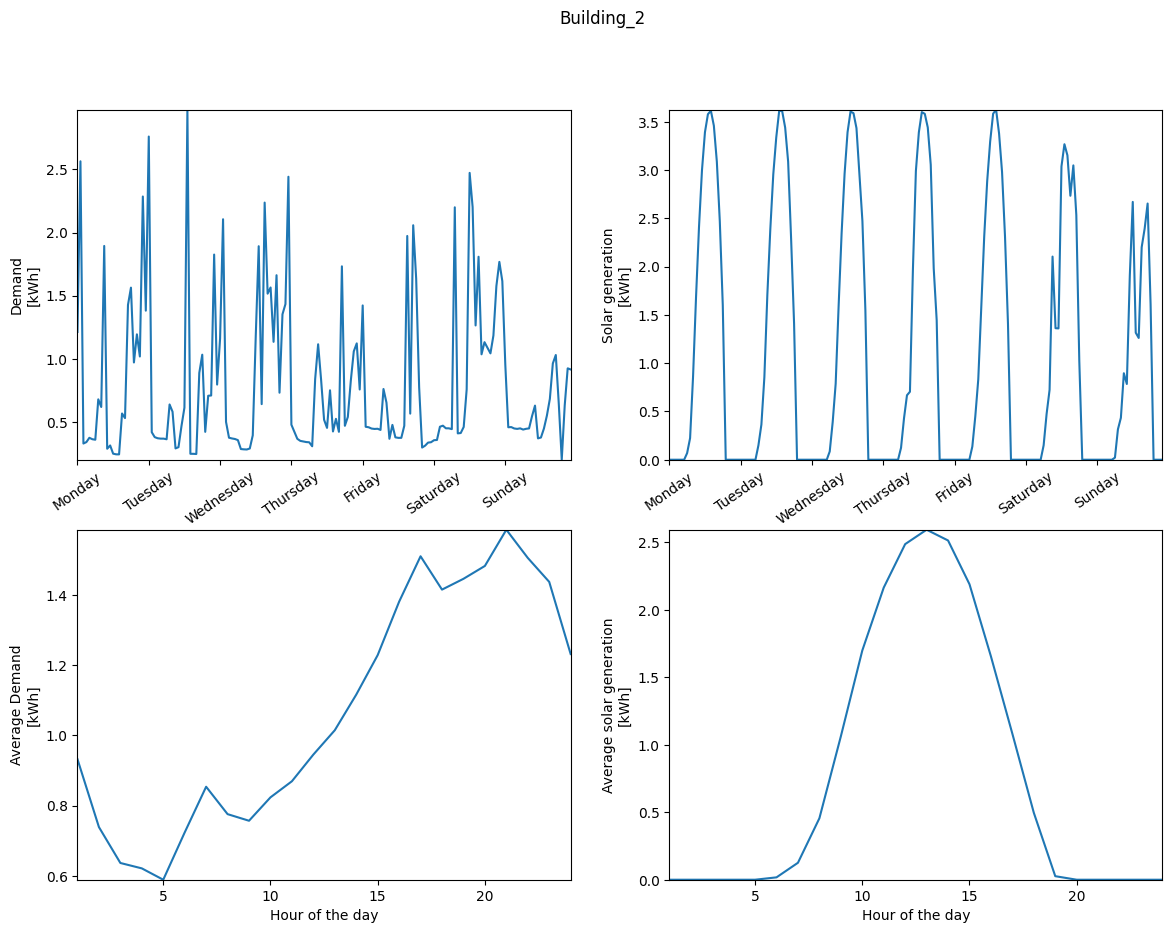

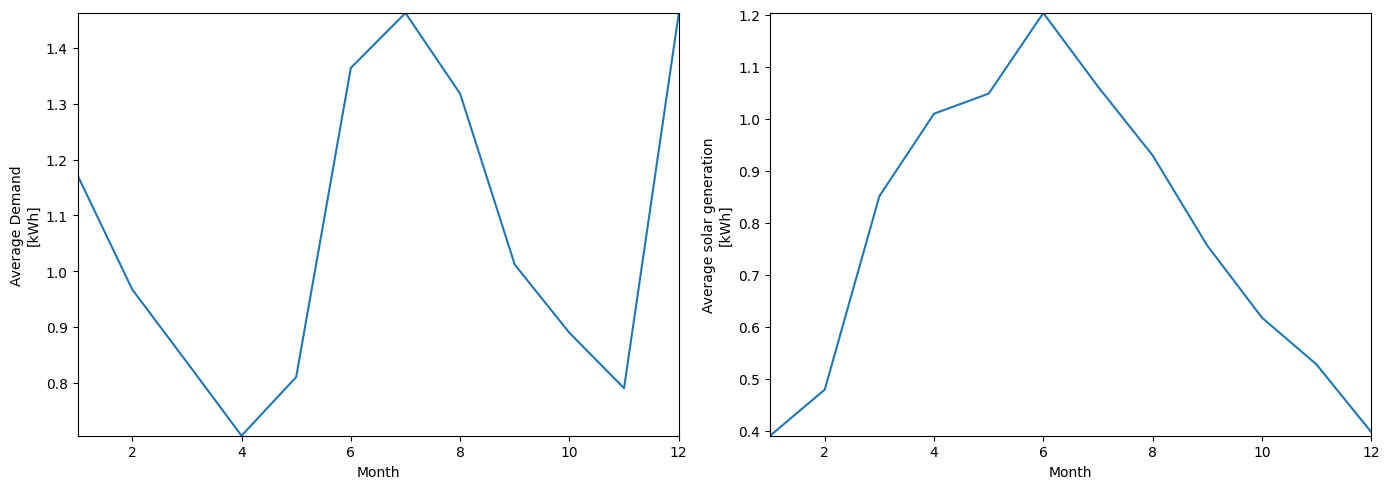

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming building_data is a DataFrame with 'hour', 'month', and 'day' columns
# Aggregating data by hour of the day
hourly_data = building_data.groupby('hour').mean()

# Aggregating data by month
monthly_data = building_data.groupby('month').mean()

# List of month names starting from August
# month_names = ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))


# 7392, 7559


day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Original plots
x =building_data[7392: 7559].index
y1 = building_data[7392: 7559]['non_shiftable_load']
y2 = building_data[7392: 7559]['solar_generation'] / 1000 * 5.0

axs[0, 0].plot(x, y1)
axs[0, 0].set_xlabel('Hour')
axs[0, 0].set_ylabel('Demand\n[kWh]')

axs[0, 0].set_xticks(x[::24])  # Set x-ticks every 730 hours
axs[0, 0].set_xticklabels(day_names)  # Label ticks with month names
plt.setp(axs[0, 0].get_xticklabels(), rotation=35)  # Rotate tick labels by 90 degrees



axs[0, 1].plot(x, y2)
axs[0, 1].set_xlabel('Hour')
axs[0, 1].set_ylabel('Solar generation\n[kWh]')
# axs[0, 1].set_xticks(range(0, len(building_data[7392: 7559]), 24))  # Set x-ticks every 730 hours
# axs[0, 1].set_xticklabels(day_names)  # Label ticks with month names
# plt.setp(axs[0, 1].get_xticklabels(), rotation=90)  # Rotate tick labels by 90 degrees
axs[0, 1].set_xticks(x[::24])  # Set x-ticks every 730 hours
axs[0, 1].set_xticklabels(day_names)  # Label ticks with month names
plt.setp(axs[0, 1].get_xticklabels(), rotation=35)  # Rotate tick labels by 90 degrees


# Plotting non-shiftable load aggregated by hour of the day
axs[1, 0].plot(hourly_data.index, hourly_data['non_shiftable_load'])
axs[1, 0].set_xlabel('Hour of the day')
axs[1, 0].set_ylabel('Average Demand\n[kWh]')

# Plotting solar generation aggregated by hour of the day
axs[1, 1].plot(hourly_data.index, hourly_data['solar_generation']/ 1000 * 5.0)
axs[1, 1].set_xlabel('Hour of the day')
axs[1, 1].set_ylabel('Average solar generation\n[kWh]')

# Plotting non-shiftable load aggregated by month
fig_month, axs_month = plt.subplots(1, 2, figsize=(14, 5))
axs_month[0].plot(monthly_data.index, monthly_data['non_shiftable_load'])
axs_month[0].set_xlabel('Month')
axs_month[0].set_ylabel('Average Demand\n[kWh]')

# Plotting solar generation aggregated by month
axs_month[1].plot(monthly_data.index, monthly_data['solar_generation']/ 1000 * 5.0)
axs_month[1].set_xlabel('Month')
axs_month[1].set_ylabel('Average solar generation\n[kWh]')

fig.suptitle(building_name)
plt.tight_layout()

# Save the figure
fig.savefig('building_data_plots.png', dpi=300)

# Show the plot
plt.show()

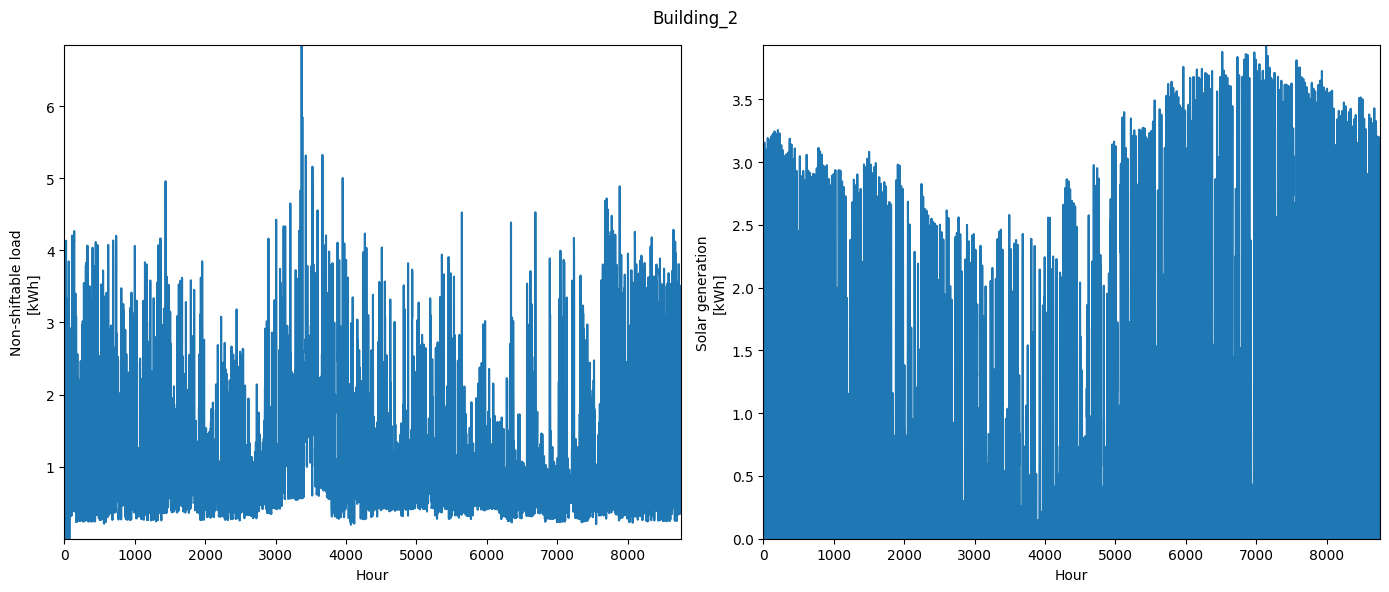

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
x = building_data.index
y1 = building_data['non_shiftable_load']
y2 = building_data['solar_generation'] / 1000 * 5.0
axs[0].plot(x, y1)
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Non-shiftable load\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Solar generation\n[kWh]')
fig.suptitle(building_name)
plt.tight_layout()
plt.show()

### Preview Weather File


In [33]:
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())

,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


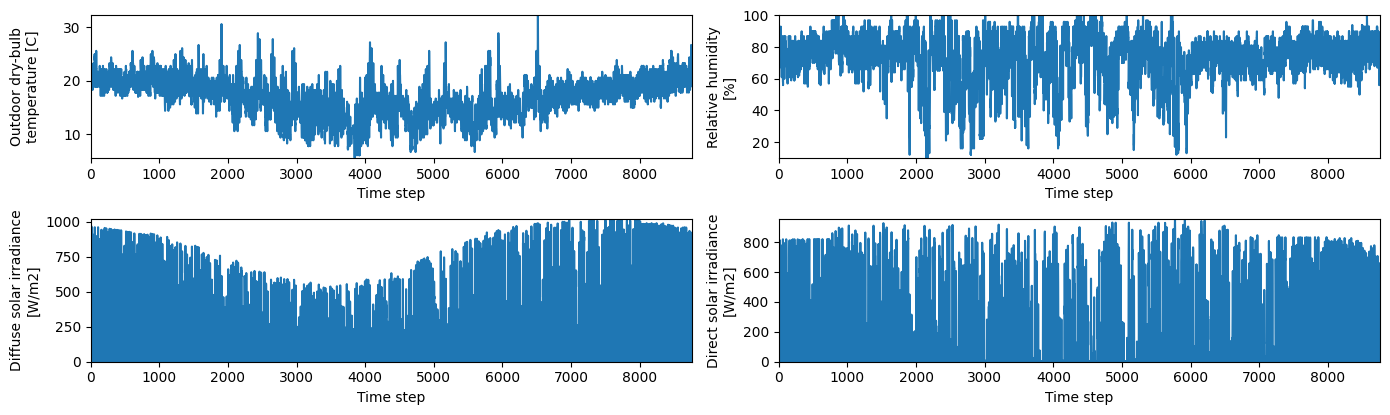

In [34]:
columns = [
    'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity',
    'diffuse_solar_irradiance', 'direct_solar_irradiance'
]
titles = [
    'Outdoor dry-bulb\ntemperature [C]', 'Relative humidity\n[%]',
    'Diffuse solar irradiance\n[W/m2]', 'Direct solar irradiance\n[W/m2]'
]
fig, axs = plt.subplots(2, 2, figsize=(14, 4.25))
x = weather_data.index

for ax, c, t in zip(fig.axes, columns, titles):
    y = weather_data[c]
    ax.plot(x, y)
    ax.set_xlabel('Time step')
    ax.set_ylabel(t)

fig.align_ylabels()
plt.tight_layout()
plt.show()

### Preview Electricity Price Data


Table: Time-Of-Use rate plan ($/kWh).

| | June-September |  | October-May |  |
|---|---|---|---|---|
| **Time** | **Weekday** | **Weekend** | **Weekday** | **Weekend** |
| 8 AM-4 PM | 0.21 | 0.21 | 0.20 | 0.20 |
| 4 PM-9 PM | 0.54 | 0.40 | 0.50 | 0.50 |
| 9 PM-8 AM | 0.21 | 0.21 | 0.20 | 0.20 |

The electricity pricing time series is shown below. It has four fields including perfect forecast of the pricing 6, 12 and 24 hours ahead.

## Data Preprocessing


### Helper functions

In [35]:
def select_buildings(
dataset_name: str, count: int, seed: int, buildings_to_exclude: list[str] = None,
) -> list[str]:
    """Randomly select buildings from CityLearn dataset.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator
    buildings_to_exclude: list[str]
        List of buildings to exclude from selection pool.

    Returns
    -------
    buildings: list[str]
        List of selected building names.
    """

    assert 1 <= count <= 15, 'count must be between 1 and 15.'

    # set random seed
    np.random.seed(seed)

    # get all building names
    schema = DataSet.get_schema(dataset_name)
    buildings = list(schema['buildings'].keys())

    # remove buildins 12 and 15 as they have pecularities in their data
    # that are not relevant to this tutorial
    buildings_to_exclude = [] if buildings_to_exclude is None \
        else [b for b in buildings_to_exclude]
    buildings_to_exclude += ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, size=count, replace=False).tolist()

    # reorder buildings
    building_ids = [int(b.split('_')[-1]) for b in buildings]
    building_ids = sorted(building_ids)
    buildings = [f'Building_{i}' for i in building_ids]

    return buildings



def select_simulation_period(
    dataset_name: str, count: int, seed: int,
    simulation_periods_to_exclude: list[tuple[int, int]] = None
) -> tuple[int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.
    simulation_periods_to_exclude: list[tuple[int, int]]
        List of simulation periods to exclude from selection pool.

    Returns
    -------
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps
    schema = DataSet.get_schema(dataset_name)
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # exclude period if needed
    if simulation_periods_to_exclude is not None:
        simulation_start_time_step_list_to_exclude = \
            [s for s, e in simulation_periods_to_exclude]
        simulation_start_time_step_list = np.setdiff1d(
            simulation_start_time_step_list,
            simulation_start_time_step_list_to_exclude
        )

    else:
        pass

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    return simulation_start_time_step, simulation_end_time_step

### Setting your Random Seed



In [36]:
RANDOM_SEED = 0
print('Random seed:', RANDOM_SEED)

Random seed: 0


### Setting the Buildings, Time Periods and Observations to use in Simulations from the Schema

Now we can pseudo-randomly select buildings and time periods as well as set the active observations and cotrol configureation we will use. We use constants to define them which we will parse to the CityLearn `__init__` contructor function when initializing a new environment.

In [37]:
BUILDING_COUNT = 1
BUILDINGS = select_buildings(
    DATASET_NAME,
    BUILDING_COUNT,
    RANDOM_SEED,
)
print('Selected building:', BUILDINGS)

Selected building: ['Building_2']


# Selecting the evaluation time period

In [38]:
DAY_COUNT = 7
SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP = select_simulation_period(
    DATASET_NAME,
    DAY_COUNT,
    RANDOM_SEED
)

print(
    f'Selected {DAY_COUNT}-day simulation period:',
    (SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP)
)

Selected 7-day simulation period: (7392, 7559)


In [39]:
SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP, SIMULATION_END_TIME_STEP - SIMULATION_START_TIME_STEP

(7392, 7559, 167)

In [40]:
ACTIVE_OBSERVATIONS = ['hour', 'day_type', 'month', 'electrical_storage_soc' , 'net_electricity_consumption', 'electricity_pricing' ,'solar_generation']
# ACTIVE_OBSERVATIONS = ['hour', 'electrical_storage_soc']

In [41]:
CENTRAL_AGENT = True  #Single Agent

# Initialize a CityLearn Environment


In [42]:
env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

In [44]:
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))

Current time step: 0
environment number of time steps: 168
environment uses central agent: True
Number of buildings: 1


# KPI's
---

We evaluate the control agents' performance using five key performance indicators (KPIs) that are to be minimized: electricity cost, carbon emissions, average daily peak, ramping, and (1 - load factor). Average daily peak, ramping and (1 - load factor) are district-level KPIs that are calculated using the aggregated district-level hourly net electricity consumption (kWh), $E_h^{\textrm{district}}$. Electricity cost, and carbon emissions are building-level KPIs that are calculated using the building-level hourly net electricity consumption (kWh), $E_h^{\textrm{building}}$, and are reported at the grid level as the average of the building-level values.

Electricity cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$ (\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$



# Helper Functions to Display Simulation Results


In [47]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.unwrapped.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = {
        'cost_total': 'Cost',
        'carbon_emissions_total': 'Emissions',
        'daily_peak_average': 'Avg. daily peak',
        'ramping_average': 'Ramping',
        'monthly_one_minus_load_factor_average': '1 - load factor'
    }
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()
    kpis['cost_function'] = kpis['cost_function'].map(lambda x: kpi_names[x])

    # round up the values to 2 decimal places for readability
    kpis['value'] = kpis['value'].round(2)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis


def plot_building_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        for j, _ in enumerate(envs):
            ax.bar_label(ax.containers[j], fmt='%.2f')

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    return fig



def plot_district_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for j, _ in enumerate(envs):
        ax.bar_label(ax.containers[j], fmt='%.2f')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig



def plot_building_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.unwrapped.buildings[i].net_electricity_consumption
            y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_ylabel('kWh')

        if daily_average:
            ax.set_xlabel('Hour')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

        else:
            ax.set_xlabel('Time step')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

def plot_district_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.unwrapped.net_electricity_consumption
        y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_ylabel('kWh')

    if daily_average:
        ax.set_xlabel('Hour')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

    else:
        ax.set_xlabel('Time step')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig



def plot_battery_soc_profiles(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = np.array(v.unwrapped.buildings[i].electrical_storage.soc)
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
        ax.set_ylim(0.0, 1.0)

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig


def plot_simulation_summary(envs: dict[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    print('#'*8 + ' BUILDING-LEVEL ' + '#'*8)
    print('Building-level KPIs:')
    _ = plot_building_kpis(envs)
    plt.show()

    

# Defining Training Period

In [51]:

# Define the number of weeks prior to the simulation start time for training
N = 10  # You can change this to any number of weeks you want

# Calculate the training start and end time steps
TRAIN_START_TIME_STEP, TRAIN_END_TIME_STEP = SIMULATION_START_TIME_STEP - (24 * 7 * N), SIMULATION_START_TIME_STEP - 1


TRAIN_START_TIME_STEP, TRAIN_END_TIME_STEP, TRAIN_END_TIME_STEP - TRAIN_START_TIME_STEP

(5712, 7391, 1679)

# Plotting Training period versus Evaluating Period

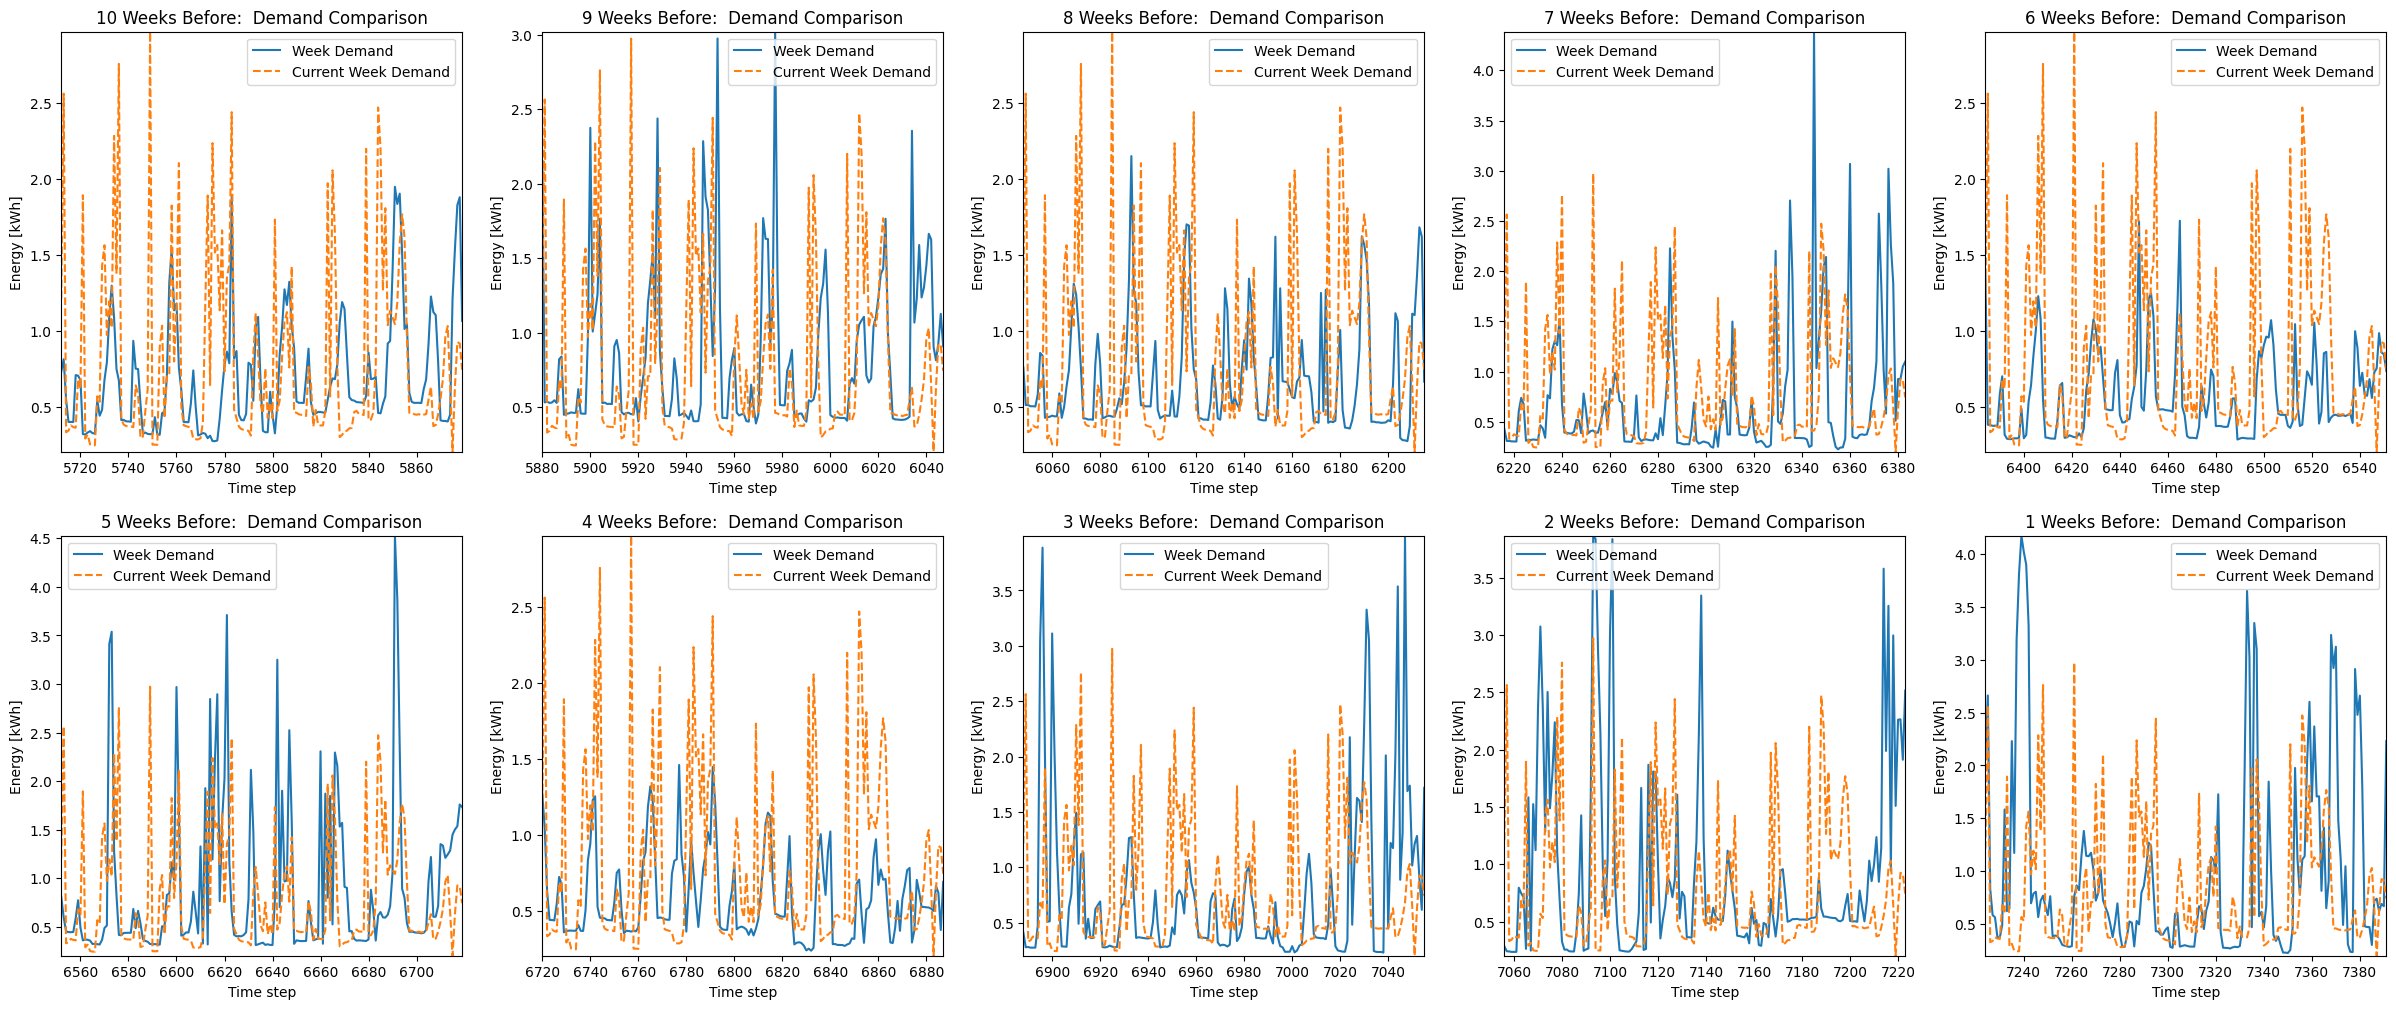

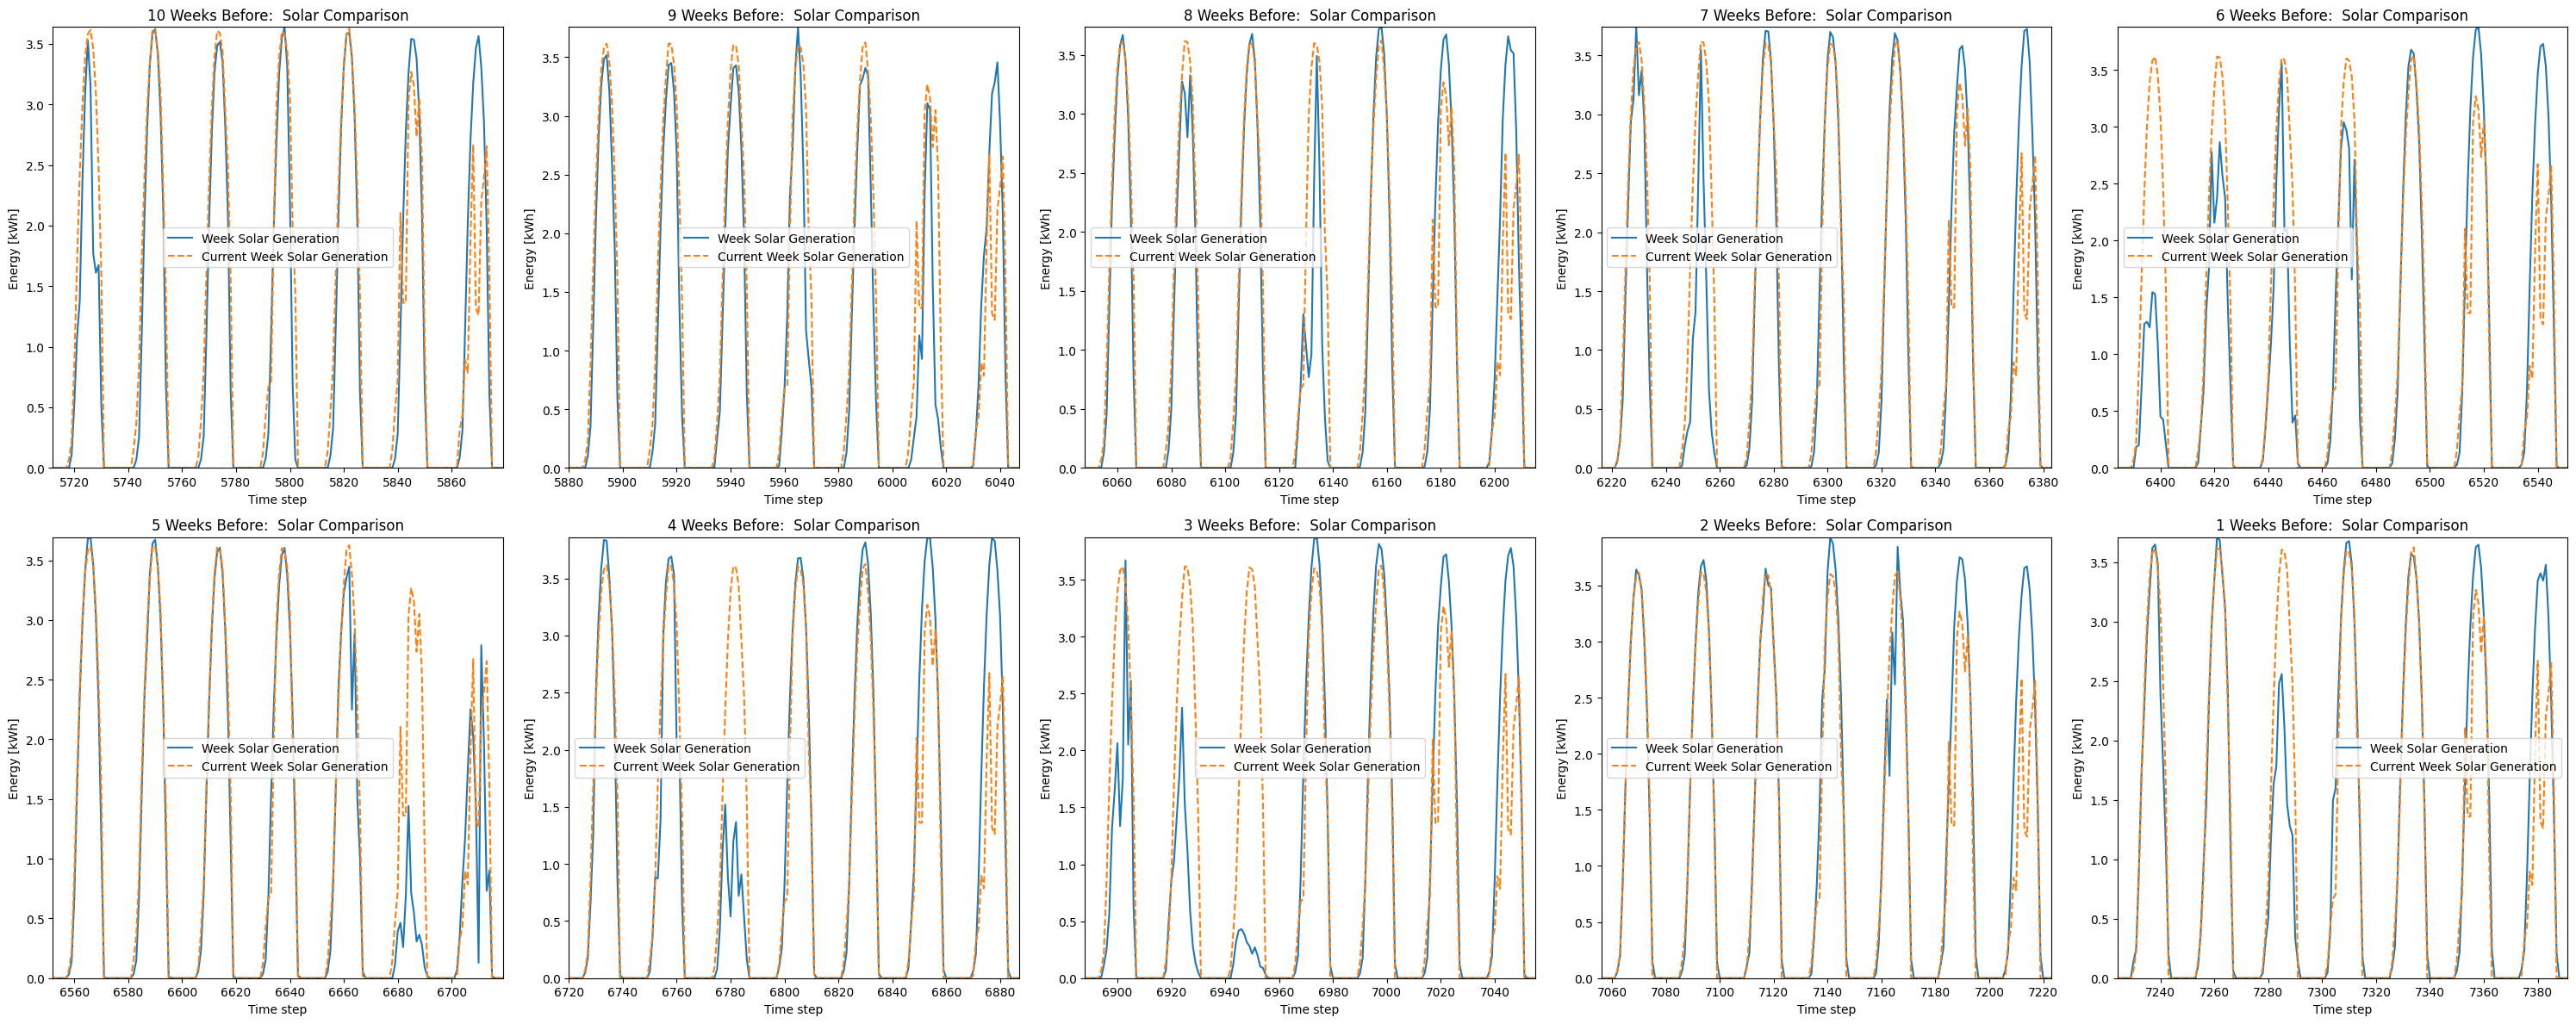

In [52]:
# Define the number of weeks to plot
num_weeks = N
hours_per_week = 24 * 7

# Create a 2x5 grid for demand comparison
fig_demand, axs_demand = plt.subplots(2, 5, figsize=(30, 12))

# Create a 2x5 grid for solar generation comparison
fig_solar, axs_solar = plt.subplots(2, 5, figsize=(30, 12))

# Loop through each week in reverse order
for week in range(num_weeks):
    start = SIMULATION_START_TIME_STEP - (num_weeks - week) * hours_per_week
    end = start + hours_per_week
    
    x = building_data[start:end].index
    y1 = building_data[start:end]['non_shiftable_load']
    y2 = building_data[start:end]['solar_generation'] / 1000 * 5.0

    # Plot demand comparison
    ax_demand = axs_demand[week // 5, week % 5]
    ax_demand.plot(x, y1, label='Week Demand')
    ax_demand.plot(x, building_data[SIMULATION_START_TIME_STEP:SIMULATION_START_TIME_STEP + hours_per_week]['non_shiftable_load'], label='Current Week Demand', linestyle='--')
    ax_demand.set_xlabel('Time step')
    ax_demand.set_ylabel('Energy [kWh]')
    ax_demand.set_title(f'{num_weeks - week} Weeks Before:  Demand Comparison')
    ax_demand.legend()

    # Plot solar generation comparison
    ax_solar = axs_solar[week // 5, week % 5]
    ax_solar.plot(x, y2, label='Week Solar Generation')
    ax_solar.plot(x, building_data[SIMULATION_START_TIME_STEP:SIMULATION_START_TIME_STEP + hours_per_week]['solar_generation'] / 1000 * 5.0, label='Current Week Solar Generation', linestyle='--')
    ax_solar.set_xlabel('Time step')
    ax_solar.set_ylabel('Energy [kWh]')
    ax_solar.set_title(f'{num_weeks - week} Weeks Before:  Solar Comparison')
    ax_solar.legend()

plt.tight_layout()
plt.show()

In [53]:
ACTIVE_OBSERVATIONS = ['hour', 'day_type', 'month', 'electrical_storage_soc' , 'net_electricity_consumption', 'electricity_pricing' ,'solar_generation']
# ACTIVE_OBSERVATIONS = ['hour', 'day_type', 'month', 'electrical_storage_soc', 'electricity_pricing', 'carbon_intensity', 'solar_generation' ]


# Baseline


In [54]:
baseline_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

In [57]:
baseline_model = BaselineAgent(baseline_env)

In [58]:
# always start by reseting the environment
observations, _ = baseline_env.reset()

# step through the environment until terminal
# state is reached i.e., the control episode ends


building = baseline_env.buildings[0]
storage = building.electrical_storage

i = 1
while not baseline_env.terminated:

    
    i+=1
    # select actions from the model
    actions = baseline_model.predict(observations)

    # apply selected actions to the environment

    observations, _, _, _, _ = baseline_env.step(actions)

# Rule-Based

######## BUILDING-LEVEL ########
Building-level KPIs:


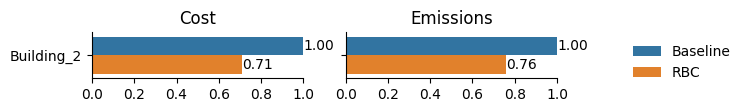

In [59]:
# define action map
soc_values_rbc =  []
net_rbc = []
electricity_price_rbc = []
actions_rbc = []
solar_rbc = []


nbr_back_up_call = 0

back_up = True

action_map = {
    1: 0.0,
    2: 0.0,
    3: 0.0,
    4: 0.0,
    5: 0.0,
    6: 0.0,
    7: 0.0,
    8: 0.10,
    9: 0.10,
    10: 0.10,
    11: 0.10,
    12: 0.10,
    13: 0.15,
    14: 0.15,
    15: 0.15,
    16: 0.05,
    17: 0.0,
    18: -0.10,
    19: -0.20,
    20: -0.20,
    21: -0.10,
    22: -0.10,
    23: -0.10,
    24: -0.10,
}



# run inference
rbc_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)





rbc_model = HourRBC(rbc_env, action_map=action_map)
observations, _ = rbc_env.reset()

building = rbc_env.buildings[0]
storage = building.electrical_storage




i=0

while not rbc_env.terminated:


    actions = rbc_model.predict(observations)



    ## Discretizing the actionss


    # if actions[0][0] > 0.3:
    #   actions = [[0.3]]

    # elif actions[0][0] < -0.3:
    #   actions = [[-0.3]]

    # elif actions[0][0] > 0.05:
    #   actions = [[0.15]]

    # elif actions[0][0] < -0.05:
    #   actions = [[-0.15]]

    # elif 0.0 <actions[0][0] < 0.05:
    #   actions = [[0.0]]

    # elif -0.05 <actions[0][0] < 0.0:
    #   actions = [[0.0]]
       




    if back_up:

      soc_current = storage.soc[building.time_step]
      if soc_current  > 0.90 :
        nbr_back_up_call +=1
        actions = [[-0.10]]

      elif soc_current < 0.10:
        nbr_back_up_call +=1
        actions = [[0.10]]


    




    observations, _, _, _, _ = rbc_env.step(actions)


    net_rbc.append(observations[0][-2])
    electricity_price_rbc.append(observations[0][-1])
    solar_rbc.append(observations[0][3])





    time_step = rbc_env.buildings[0].electrical_storage.time_step
    soc = rbc_env.buildings[0].electrical_storage.soc[storage.time_step]




    soc_values_rbc.append(soc)
    actions_rbc.append(actions[0][0])

    # if i >=2:
    #   break

    i+=1

    # break

# display simulation summary
plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    'RBC': rbc_env,
})

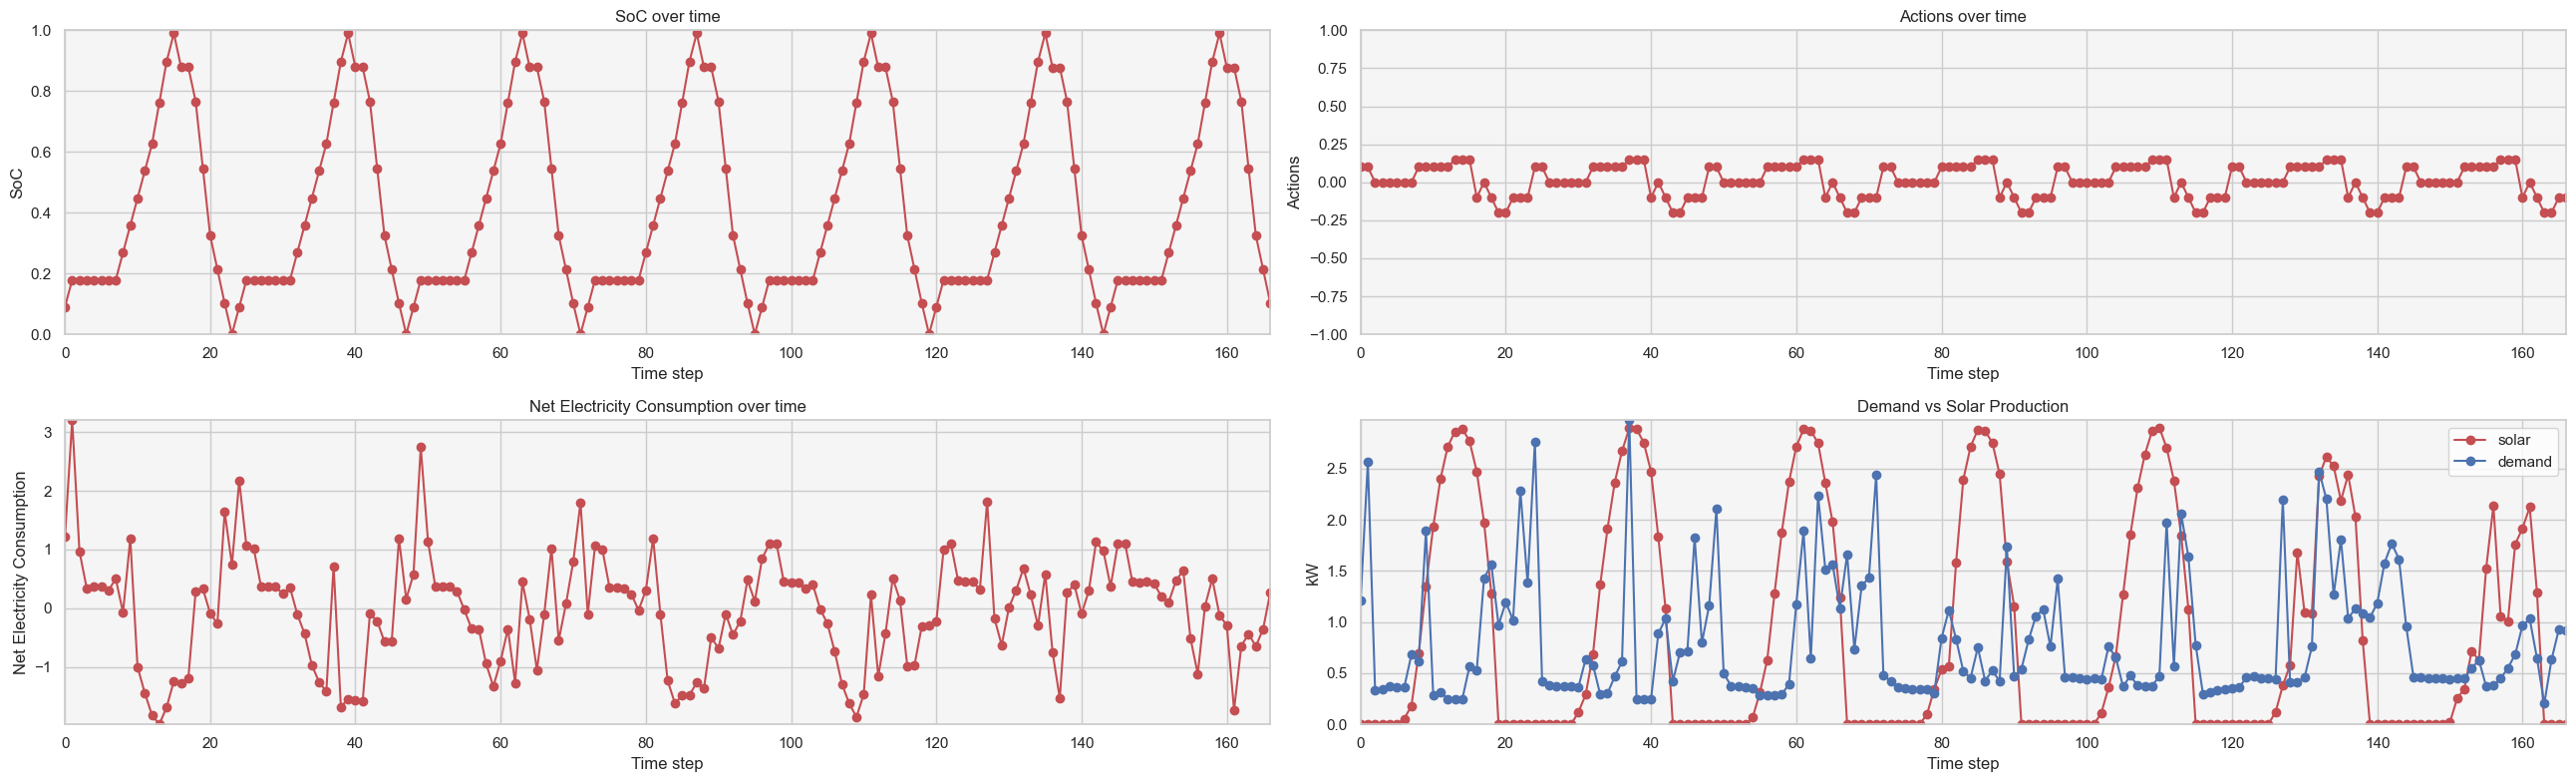

       Metric  Count
0  SoC < 0.10     13
1  SoC > 0.90      7
Number of Back up calls: 21


In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(26, 8))

soc_values_rbc = np.array(soc_values_rbc)
actions_rbc = np.array(actions_rbc)

# Plot SoC values
axes[0][0].plot(soc_values_rbc, marker='o', linestyle='-', color='r')
axes[0][0].set_xlabel('Time step')
axes[0][0].set_ylabel('SoC')
axes[0][0].set_ylim((0, 1))
axes[0][0].set_title('SoC over time')

# Plot Actions
axes[0][1].plot(actions_rbc, marker='o', linestyle='-', color='r')
axes[0][1].set_xlabel('Time step')
axes[0][1].set_ylabel('Actions')
axes[0][1].set_ylim((-1, 1))
axes[0][1].set_title('Actions over time')


# Plot Actions
axes[1][0].plot(rbc_env.buildings[0].net_electricity_consumption[:-1], marker='o', linestyle='-', color='r')
# axes[1][0].plot(net_rbc, marker='o', linestyle='-', color='r')
# axes[1][0].plot(building_data[7392: 7559]['non_shiftable_load'], marker='o', linestyle='-', color='r')
axes[1][0].set_xlabel('Time step')
axes[1][0].set_ylabel('Net Electricity Consumption')
# axes[1][0].set_ylim((-1, 1))
axes[1][0].set_title('Net Electricity Consumption over time')


# Plot Actions
axes[1][1].plot(-1*rbc_env.buildings[0].solar_generation[:-1], marker='o', linestyle='-', color='r', label = 'solar')
axes[1][1].plot(rbc_env.buildings[0].non_shiftable_load[:-1], marker='o', linestyle='-', color='b', label = 'demand')
axes[1][1].legend()
axes[1][1].set_xlabel('Time step')
axes[1][1].set_ylabel('kW')
# axes[1][1].set_ylim((-1, 1))
axes[1][1].set_title('Demand vs Solar Production')



# Enhance plot aesthetics
for ax in axes:
    ax[0].grid(True)
    ax[0].set_facecolor('whitesmoke')

    ax[1].grid(True)
    ax[1].set_facecolor('whitesmoke')

# Display the plots
plt.tight_layout()
plt.show()

# Create DataFrame for statistics
data = {
    'Metric': ['SoC < 0.10', 'SoC > 0.90'],
    'Count': [np.sum(soc_values_rbc < .10), np.sum(soc_values_rbc > .90)]
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)
print('Number of Back up calls:', nbr_back_up_call)

latex_code = df.to_latex(index=False)
# print(latex_code)

## Defining a Custom Reward Function



In [64]:
from typing import Any, Dict, List, Union

class CustomReward(RewardFunction):
    def __init__(self, env_metadata: Dict[str, Any]):
        r"""Initialize CustomReward.

        Parameters
        ----------
        env_metadata: dict[str, Any]:
            General static information about the environment.
        """
        super().__init__(env_metadata)

    def calculate(
        self, observations: List[Dict[str, Union[int, float]]]
    ) -> List[float]:
        r"""Returns reward for most recent action.

        The reward is designed to minimize electricity cost.
        It is calculated for each building, i and summed to provide the agent
        with a reward that is representative of all n buildings.
        It encourages net-zero energy use by penalizing grid load satisfaction
        when there is energy in the battery as well as penalizing
        net export when the battery is not fully charged through the penalty
        term. There is neither penalty nor reward when the battery
        is fully charged during net export to the grid. Whereas, when the
        battery is charged to capacity and there is net import from the
        grid the penalty is maximized.

        Parameters
        ----------
        observations: list[dict[str, int | float]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: list[float]
            Reward for transition to current timestep.
        """
    



        reward_list = []

        for o, m in zip(observations, self.env_metadata['buildings']):
            




            # Cost minimization term

            cost = o['net_electricity_consumption']*o['electricity_pricing']
            battery_soc = o['electrical_storage_soc']
            penalty = -(1.0 + np.sign(cost)*battery_soc)
            reward = penalty*abs(cost)


            
            # Penalty for breaking constraints

            if battery_soc > .90:
                reward = reward - 75*(battery_soc - 0.90)**2
            elif battery_soc < .10:
                reward = reward - 75*(0.10 - battery_soc)**2




            reward_list.append(reward)

        reward = [sum(reward_list)]

        
        return reward

# Training SAC or others Deep RL algorithms

In [65]:
sacr_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TRAIN_START_TIME_STEP,
    simulation_end_time_step=TRAIN_END_TIME_STEP,
    reward_function=CustomReward, # assign custom reward function
)
sacr_env = NormalizedObservationWrapper(sacr_env)
# sacr_env = DiscreteActionWrapper(sacr_env)  # Use to discretize actions space but need a comptabilty Deep RL algorithms that can handle discrete action space
sacr_env = StableBaselines3Wrapper(sacr_env)



# Pick the Deep RL algorithms to use

sacr_model = SAC(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)
# sacr_model = PPO(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)
# sacr_model = DDPG(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)
# sacr_model = A2C(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)

sacr_episode_timesteps = sacr_env.unwrapped.time_steps - 1

start_time = time.time()

for i in tqdm(range(2)):
    sacr_model = sacr_model.learn(
        total_timesteps=sacr_episode_timesteps,
        reset_num_timesteps=False,
    )

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken for training: {elapsed_time:.2f} seconds")

100%|██████████| 2/2 [02:02<00:00, 61.07s/it]

Time taken for training: 122.17 seconds


# EVALUATING THE RL AGENT

In [66]:
#Evaluating on a differnt time sequences


sacr_env_eval = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
    reward_function=CustomReward, # assign custom reward function
)
sacr_env_eval = NormalizedObservationWrapper(sacr_env_eval)
# sacr_env = DiscreteActionWrapper(sacr_env)
sacr_env_eval = StableBaselines3Wrapper(sacr_env_eval)

/Users/leobenac/Desktop/Derms/CityLearn/dermsvenv/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


######## BUILDING-LEVEL ########
Building-level KPIs:


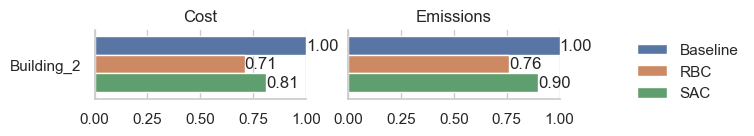

In [67]:
observations, _ = sacr_env_eval.reset()

sac_actions = []
soc_values_sac = []
# sac_plus_actions = []


back_up = True
nbr_back_up_call_sac = 0



# assert (back_up == True) or (back_up_smooth == True)

building = sacr_env_eval.buildings[0]
storage = building.electrical_storage

while not sacr_env_eval.unwrapped.terminated:


    actions, _ = sacr_model.predict(observations, deterministic=True)
    soc_current = storage.soc[building.time_step]


    ## Discretizing the actionss

    # if actions[0] > 0.3:
    #   actions = [0.3]

    # elif actions[0] < -0.3:
    #   actions = [-0.3]

    # elif actions[0] > 0.05:
    #   actions = [0.15]

    # elif actions[0] < -0.05:
    #   actions = [-0.15]

    # elif 0.0 <actions[0] < 0.05:
    #   actions = [0.0]

    # elif -0.05 <actions[0] < 0.0:
    #   actions = [0.0]
       


    if back_up:

        soc_current = storage.soc[building.time_step]
        if soc_current  > 0.90 :
          nbr_back_up_call_sac +=1
          actions = [-0.10]

        elif soc_current < 0.10:
          nbr_back_up_call_sac +=1
          actions = [0.10]


    action = actions[0]



    observations, _, _, _, _ = sacr_env_eval.step(actions)
    sac_actions.append(action)
    soc_values_sac.append(soc_current)




# plot summary and compare with other control results

plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    # 'RBC': rbc_env,
    # 'TQL': tql_env,
    # 'SAC-1': sac_env,
    'RBC': rbc_env,
    'SAC': sacr_env_eval
})

soc_values_sac = np.array(soc_values_sac)

# Visualization of results

/Users/leobenac/Desktop/Derms/CityLearn/dermsvenv/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


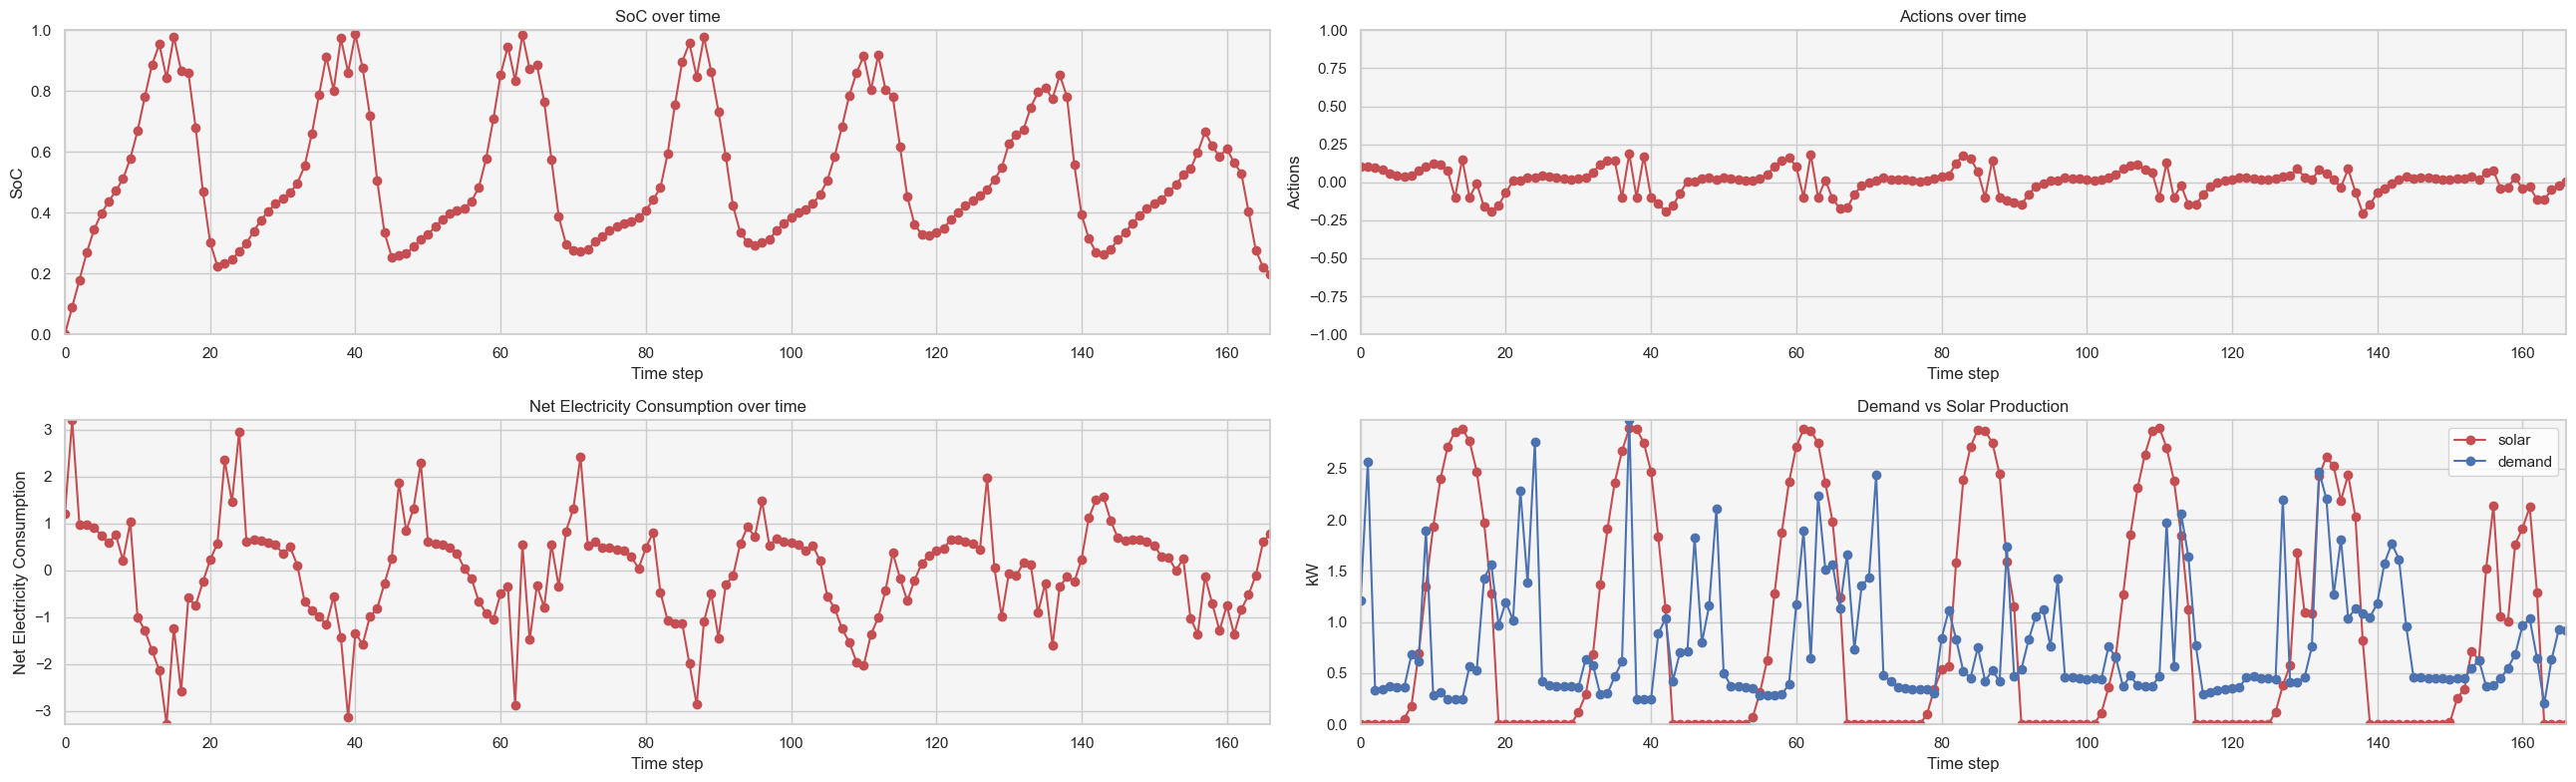

       Metric  Count
0  SoC < 0.10      2
1  SoC > 0.90     11
Number of Back up calls: 13


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(26, 8))

soc_values_rbc = np.array(soc_values_rbc)
actions_rbc = np.array(actions_rbc)

# Plot SoC values
axes[0][0].plot(soc_values_sac, marker='o', linestyle='-', color='r')
axes[0][0].set_xlabel('Time step')
axes[0][0].set_ylabel('SoC')
axes[0][0].set_ylim((0, 1))
axes[0][0].set_title('SoC over time')

# Plot Actions
axes[0][1].plot(sac_actions, marker='o', linestyle='-', color='r')
axes[0][1].set_xlabel('Time step')
axes[0][1].set_ylabel('Actions')
axes[0][1].set_ylim((-1, 1))
axes[0][1].set_title('Actions over time')


# Plot Actions
axes[1][0].plot(sacr_env_eval.buildings[0].net_electricity_consumption[:-1], marker='o', linestyle='-', color='r')
# axes[1][0].plot(net_rbc, marker='o', linestyle='-', color='r')
# axes[1][0].plot(building_data[7392: 7559]['non_shiftable_load'], marker='o', linestyle='-', color='r')
axes[1][0].set_xlabel('Time step')
axes[1][0].set_ylabel('Net Electricity Consumption')
# axes[1][0].set_ylim((-1, 1))
axes[1][0].set_title('Net Electricity Consumption over time')


# Plot Actions
axes[1][1].plot(-1*sacr_env_eval.buildings[0].solar_generation[:-1], marker='o', linestyle='-', color='r', label = 'solar')
axes[1][1].plot(sacr_env_eval.buildings[0].non_shiftable_load[:-1], marker='o', linestyle='-', color='b', label = 'demand')
axes[1][1].legend()
axes[1][1].set_xlabel('Time step')
axes[1][1].set_ylabel('kW')
# axes[1][1].set_ylim((-1, 1))
axes[1][1].set_title('Demand vs Solar Production')



# Enhance plot aesthetics
for ax in axes:
    ax[0].grid(True)
    ax[0].set_facecolor('whitesmoke')

    ax[1].grid(True)
    ax[1].set_facecolor('whitesmoke')

# Display the plots
plt.tight_layout()
plt.show()

# Create DataFrame for statistics
data = {
    'Metric': ['SoC < 0.10', 'SoC > 0.90'],
    'Count': [np.sum(np.array(soc_values_sac) < .10), np.sum(np.array(soc_values_sac) > .90)]
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)
print('Number of Back up calls:', nbr_back_up_call_sac)

latex_code = df.to_latex(index=False)
# print(latex_code)